PLANT DISEASE DETECTION


Install & Import Libraries

In [1]:
!pip install tensorflow matplotlib

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
import random


Upload and Extract Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os, json
from zipfile import ZipFile

# Load Kaggle credentials
kaggle_dict = json.load(open("kaggle.json"))
os.environ["KAGGLE_USERNAME"] = kaggle_dict["username"]
os.environ["KAGGLE_KEY"] = kaggle_dict["key"]

# Download dataset
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

# Unzip the dataset
with ZipFile("plantvillage-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("/content/plantvillage_dataset")

print("Dataset extracted successfully!")
print(os.listdir("/content/plantvillage_dataset"))


Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
plantvillage-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset extracted successfully!
['plantvillage dataset']


Set random seeds for reproducibility

In [7]:
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

In [11]:
import os

for root, dirs, files in os.walk("/content/plantvillage_dataset"):
    if 'color' in dirs:
        print("Found 'color' folder at:", os.path.join(root, 'color'))


Found 'color' folder at: /content/plantvillage_dataset/plantvillage dataset/color


Prepare Data Generators with Augmentation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = "/content/plantvillage_dataset/plantvillage dataset/color"

img_size = 128
batch_size = 32
seed_value = 42

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% train, 20% validation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=seed_value
)

val_data = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=seed_value
)

print("Number of Classes:", len(train_data.class_indices))


Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.
Number of Classes: 38


Build CNN Model

In [12]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(train_data.class_indices), activation='softmax')
])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,309,542 (12.62 MB)

 Trainable params: 3,309,542 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

Train the model

In [13]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 266s 191ms/step - accuracy: 0.3087 - loss: 2.6213 - val_accuracy: 0.6119 - val_loss: 1.3087
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 254s 187ms/step - accuracy: 0.5670 - loss: 1.4841 - val_accuracy: 0.7158 - val_loss: 0.8935
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 253s 186ms/step - accuracy: 0.6538 - loss: 1.1644 - val_accuracy: 0.7782 - val_loss: 0.7178
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 252s 185ms/step - accuracy: 0.7024 - loss: 0.9672 - val_accuracy: 0.8286 - val_loss: 0.5419
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 253s 186ms/step - accuracy: 0.7304 - loss: 0.8729 - val_accuracy: 0.8457 - val_loss: 0.4865
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 252s 186ms/step - accuracy: 0.7519 - loss: 0.7910 - val_accuracy: 0.8421 - val_loss: 0.5007
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 251s 185ms/step - accuracy: 0.7706 - loss: 0.7262 - val_accuracy: 0.8466 - val_loss: 0.4964
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 251s 185ms/step - ac

Plot Training and Validation Results

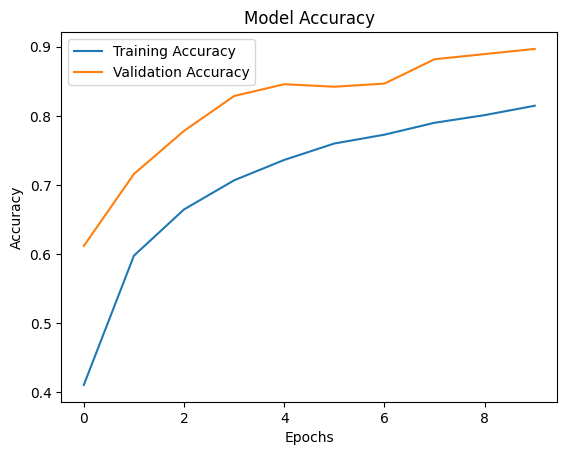

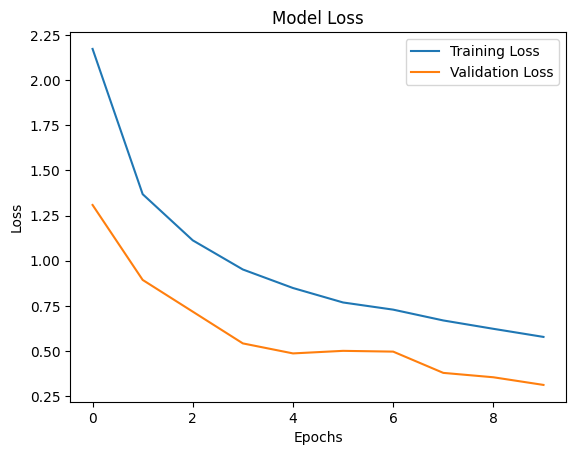

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Model Evaluation Metrics

In [20]:
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")


340/340 ━━━━━━━━━━━━━━━━━━━━ 51s 148ms/step - accuracy: 0.8955 - loss: 0.3154
Validation Accuracy: 89.88%
Validation Loss: 0.3126


In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [22]:
true_labels = val_data.classes
predictions = model.predict(val_data)
predicted_labels = np.argmax(predictions, axis=1)
class_names = list(val_data.class_indices.keys())


340/340 ━━━━━━━━━━━━━━━━━━━━ 62s 181ms/step


Classification Report

In [25]:
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n")
print(report)


Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.03      0.02      0.03       126
                                 Apple___Black_rot       0.03      0.02      0.02       124
                          Apple___Cedar_apple_rust       0.00      0.00      0.00        55
                                   Apple___healthy       0.01      0.02      0.01       329
                               Blueberry___healthy       0.03      0.03      0.03       300
          Cherry_(including_sour)___Powdery_mildew       0.02      0.02      0.02       210
                 Cherry_(including_sour)___healthy       0.00      0.00      0.00       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00       102
                       Corn_(maize)___Common_rust_       0.04      0.04      0.04       238
               Corn_(maize)___Northern_Leaf_Blight     

Confusion Matrix

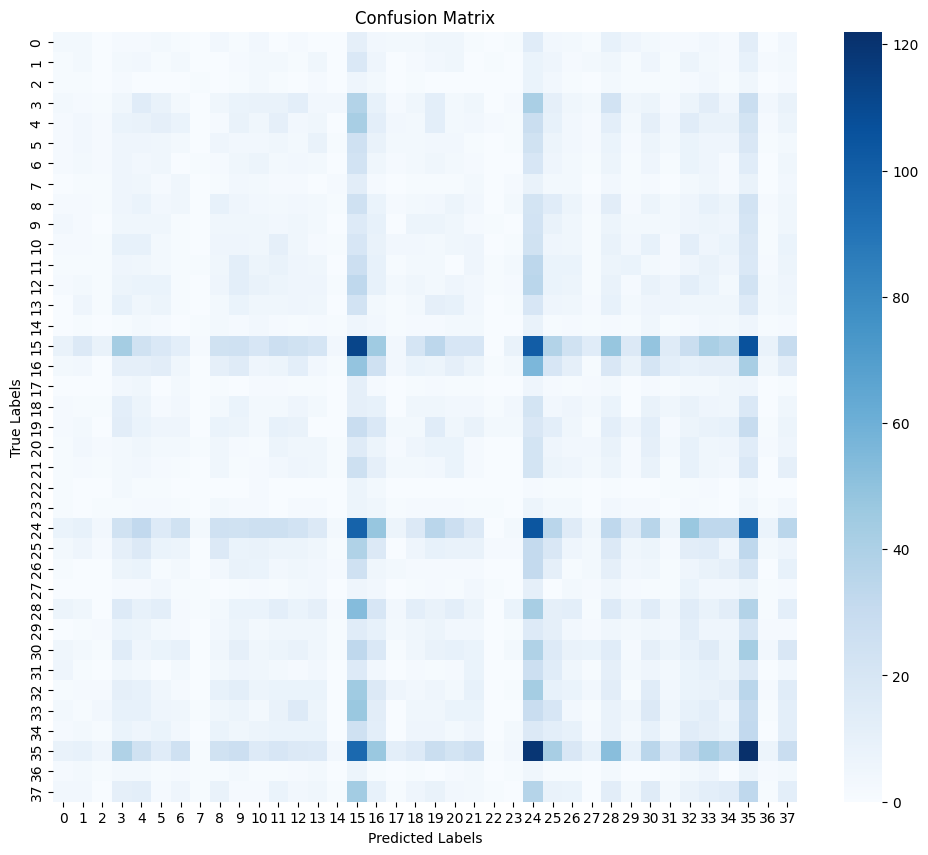

In [24]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [23]:
# overall metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f"Overall Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Overall Accuracy: 5.12%
Precision: 0.03
Recall: 0.03
F1 Score: 0.03


Save the model

In [15]:
model.save("plant_disease_cnn.h5")
print("Model saved successfully!")


Model saved successfully!


Test the Model

Prediction

Saving Screenshot 2025-11-08 141331.png to Screenshot 2025-11-08 141331 (3).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


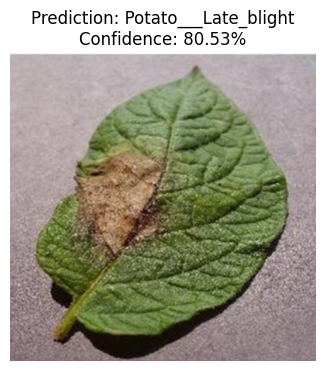

Predicted Class: Potato___Late_blight
Model Confidence: 80.53%



In [28]:
from tensorflow.keras.preprocessing import image
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np

# --- Define prediction function ---
def predict_plant_disease(model, train_data):
    uploaded = files.upload()
    for img_name in uploaded.keys():
        img_path = img_name

        # Load and preprocess
        img = image.load_img(img_path, target_size=(128, 128))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        # Predict
        pred = model.predict(img_array)
        predicted_class = np.argmax(pred, axis=1)[0]
        confidence = np.max(pred) * 100
        class_labels = list(train_data.class_indices.keys())

        # Display image and prediction
        plt.figure(figsize=(4, 4))
        plt.imshow(image.load_img(img_path))
        plt.axis('off')
        plt.title(f"Prediction: {class_labels[predicted_class]}\nConfidence: {confidence:.2f}%", fontsize=12)
        plt.show()

        # Print result
        print(f"Predicted Class: {class_labels[predicted_class]}")
        print(f"Model Confidence: {confidence:.2f}%\n")


# Call the function
predict_plant_disease(model, train_data)


Saving Screenshot 2025-11-08 144227.png to Screenshot 2025-11-08 144227.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


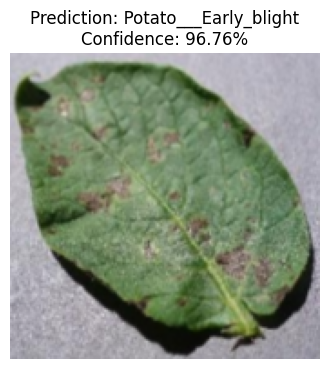

Predicted Class: Potato___Early_blight
Model Confidence: 96.76%



In [30]:
predict_plant_disease(model, train_data)